<a href="https://colab.research.google.com/github/saivenkatreddy29/Implementation-of-Hands-on-Large-Language-models-book/blob/main/Jayalamar_book_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from urllib.request import urlopen
from PIL import Image

# Updated puppy_path to the raw image URL
puppy_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
image = Image.open(urlopen(puppy_path)).convert("RGB") # Corrected 'conver' to 'convert'

caption = "a puppy playing in the snow"

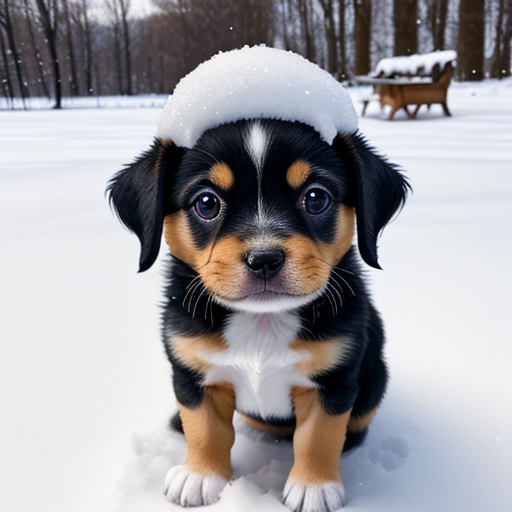

In [ ]:
image

# Embeddings

In [ ]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-large-patch14"

clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
clip_processor = CLIPProcessor.from_pretrained(model_id)

model = CLIPModel.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
inputs = clip_tokenizer(caption, return_tensors = 'pt')
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [ ]:
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 768])

In [ ]:
preprocessed_image = clip_processor(
    text = None,
    images = image,
    return_tensors = 'pt',
)['pixel_values']



In [ ]:
preprocessed_image.shape

torch.Size([1, 3, 224, 224])

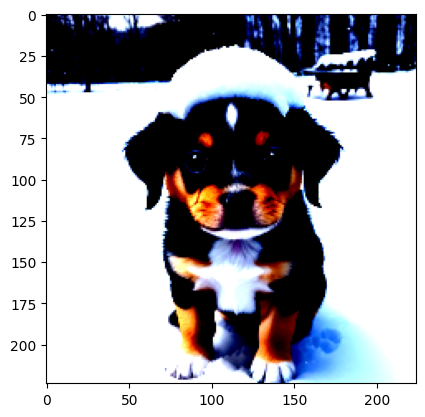

In [ ]:
import torch
import matplotlib.pyplot as plt

disp_img = preprocessed_image.squeeze()
disp_img = disp_img.permute(1,2,0)

plt.imshow(disp_img)


In [ ]:
preprocessed_image.shape

torch.Size([1, 3, 224, 224])

In [ ]:
image_embeddings = model.get_image_features(preprocessed_image)
image_embeddings.shape

torch.Size([1, 768])

In [ ]:
text_embedding /= text_embedding.norm(dim = -1, keepdim = True)
image_embeddings /= image_embeddings.norm(dim = -1, keepdim = True)


In [ ]:
# Calculate their similarity
score = text_embedding @ image_embeddings.T
score

tensor([[0.2847]], grad_fn=<MmBackward0>)

# Try for more image to get to know which is the best score

In [ ]:
from urllib.request import urlopen
from PIL import Image

cat_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png"
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
paths = [puppy_path, cat_path, car_path]

images = [Image.open(urlopen(path)).convert("RGBA") for path in paths]
captions = [
    "a puppy playing in the snow",
    "a pixalated image of cute cat",
    " A supercar on road \n with the sunset in the ground"

]

import numpy as np

image_embeddings = []

for image in images:
  image_processed = clip_processor(images = image, return_tensors = 'pt')["pixel_values"]
  image_embedding = model.get_image_features(image_processed).detach().numpy()[0]
  image_embeddings.append(image_embedding)

image_embeddings = np.array(image_embeddings)
text_embeddings = []
for caption in captions:
  captions_processed = clip_tokenizer(caption, return_tensors = 'pt')
  text_emb = model.get_text_features(**captions_processed).detach().numpy()[0]
  text_embeddings.append(text_emb)
text_embeddings = np.array(text_embeddings)



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(image_embeddings, text_embeddings)

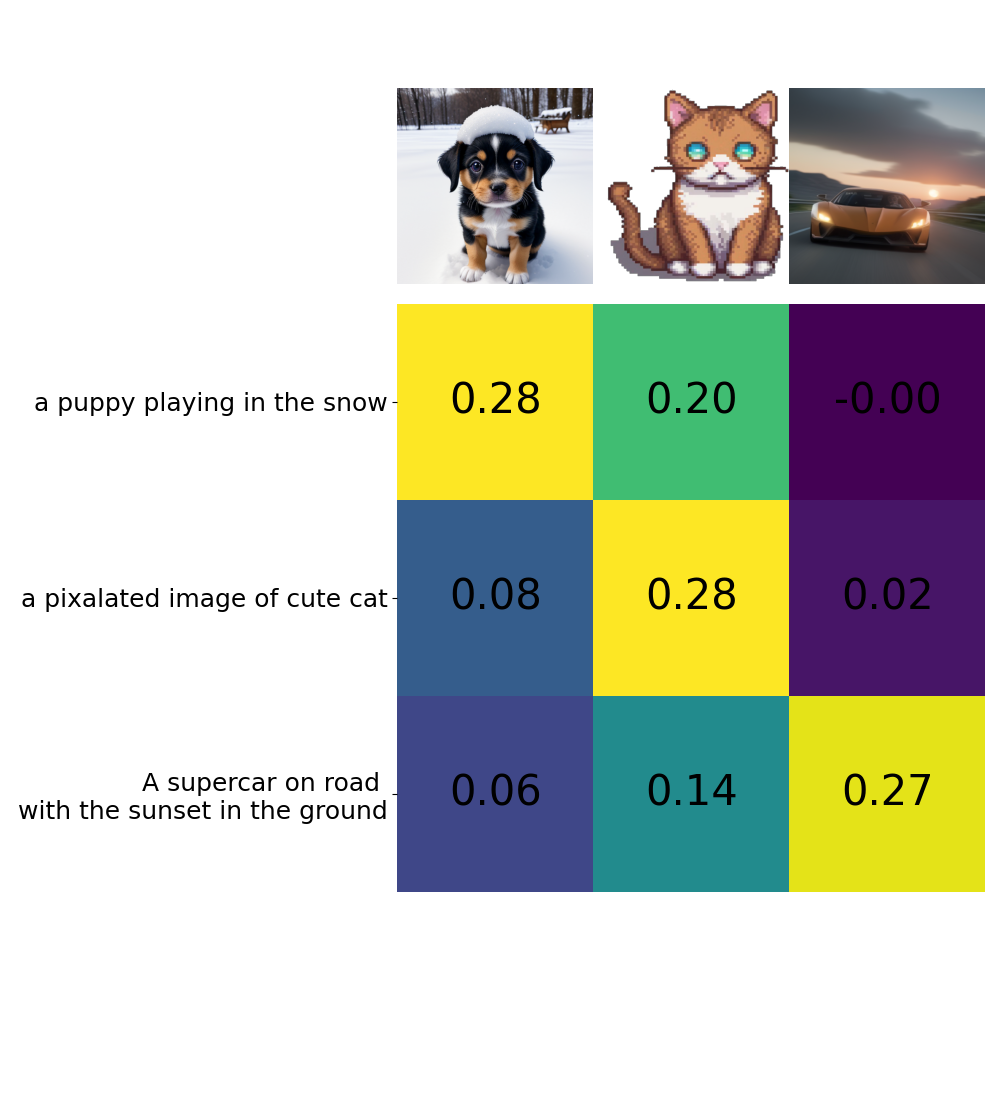

In [ ]:
# Create base figure
plt.figure(figsize=(20, 14))
plt.imshow(sim_matrix, cmap='viridis')

# Adjust ticks with correct labels
plt.yticks(range(len(captions)), captions, fontsize=18)
plt.xticks([])

# Visualize
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Add the captions at the correct indices
for x in range(sim_matrix.shape[1]):
    for y in range(sim_matrix.shape[0]):
        plt.text(x, y, f"{sim_matrix[y, x]:.2f}", ha="center", va="center", size=30)

# Remove unnecessary spines
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

# Resize blocks
plt.xlim([-0.5, len(captions) - 0.5])
plt.ylim([len(captions) + 0.5, -2])
# plt.title("Similarity Matrix", size=20)
plt.savefig("sim_matrix.png", dpi=300, bbox_inches='tight')